# Green Card Application Tracker: `trackitt.com`


The website `trackitt.com` has a very useful feature: the Green Card Tracker (I-140 tracker). This provides users with data on processing time, as well as approvals/rejections/RFEs. However, if the user wants to do their own analysis, there is no convenient way to download the data (even though it is public). Therefore, I have written this very simple scraper that downloads all cases submitted to `trackitt.com` and stores their data in a `csv` file named `trackitt_data_yyyy-mm-dd.csv`, with `yyyy`, `mm`, and `dd` the current year, month and day of the month, respectively.

Potential improvements to this code are:
- Download all applications, including ones that have been resolved
- Allow the option to only download select data (e.g. filter based on country of origin, case status, filing date, RFE y/n, etc.)
- Automatically search detailed page to replace snippet in 'notes' section with full text.

In [26]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import scrape_utils

% matplotlib inline
pd.options.display.max_columns = 30

## Download Data

### [Option 1] All data (warning: can take long)

If you simply want to download all available data for i-140 cases (which includes categories EB1, EB2, EB3, EB4 and EB5), running the following cell will store all data in a Pandas DataFrame.

In [3]:
n_pages = scrape_utils.trackitt_number_of_pages(scrape_utils.URL_DATA_TABLE % 1)

results = []
for i in range(1, (n_pages + 1)):
    if i % 100:
        print '.',
    else:
        print '%d' % i
    table = scrape_utils.trackitt_data_table_soup(scrape_utils.URL_DATA_TABLE, pagenum=i)
    results.append(scrape_utils.dataframe_from_trackitt_table(table))

data = pd.concat(results).drop_duplicates().reset_index(drop=True)

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  100 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  200 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  300 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .  400 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

### [Option 2] Select Data Using Filter

In case you are only interested in a subset of the data, for instance if you only want to include cases of the particular category you're planning to apply in, you can download a subset of the data using filters.

In [ ]:
# TODO: implement filters

### Add Notes (warning: can take long)

Some cases have notes. The basic results page containing the cases in a table clips these notes, so in order to have them complete, we have to find the cases where a note was clipped, and replace the notes in the data with the complete notes from that case page.

In [13]:
# Update notes using case page - TODO: allow for partial results
data.loc[data.Notes.str.endswith('more'), 'Notes'] = data.loc[
    data.Notes.str.endswith('more'), 'ApplicationID'].map(scrape_utils.notes_from_application_id)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

## Add number of days columns

In [15]:
data = data.assign(**{"Number Of Days Until Approved": lambda df: df.apply(
    lambda s: int(s["Total Processing Time"].split(" ")[0]) if (
        len(s["Total Processing Time"]) and s["Application Status"] == "approved") else np.nan,
    axis=1)})

In [16]:
data = (data.assign(**{
    "Number Of Days Until Approved Overall Average":
    lambda df: df["Number Of Days Until Approved"].mean(),
    "Number Of Days Until Approved Average By Category":
    lambda df: df.groupby("Category")["Number Of Days Until Approved"].transform("mean"),
    "Number Of Days Until Approved Average By Category And Service Center":
    lambda df: df.groupby(["Category", "Service Center"])["Number Of Days Until Approved"].transform("mean"),
    "Number Of Days Until Approved Average By Nationality":
    lambda df: df.groupby("Nationality")["Number Of Days Until Approved"].transform("mean")}))

# Analyses
- Average time-to-event by Category, Country
- Moving average time-to-event
- Simplified Cox model
- Competing risks analysis

In [17]:
data.head()

,ApplicationID,Watch,Username,Comments,More,Nationality,Applicant Type,Service Center,Category,Priority Date,Application Filed,USCIS Received Date,USCIS Notice Date,USCIS Receipt Number,I-140/485 Filing,...,RFE Replied Date,Application Status,Approval/Denial Date,Total Processing Time,Most Recent LUD,Days Elapsed,Notes,State,Case Added to Tracker,Last Updated,Number Of Days Until Approved,Number Of Days Until Approved Average By Category,Number Of Days Until Approved Average By Category And Service Center,Number Of Days Until Approved Average By Nationality,Number Of Days Until Approved Overall Average
0,35918,,sueanne35,2 comments,,South Korea,primary,Nebraska,EB2-NIW,06/20/2017,06/20/2017,06/20/2017,06/23/2017,LIN179073xxxx,concurrent,...,,approved,03/09/2018,262 days,,,\nPhD in Chemistry. 8 papers. 120 citations. 4...,Active,06 Jul 2017,4 minutes ago,262.0,250.735795,284.148346,193.601770,179.06057
1,38043,,swawa,0 comments,,Taiwan,primary,Nebraska,EB2-NIW,,03/09/2018,03/15/2018,,LIN18xxxxxxxx,non-concurrent,...,,pending,,,,6 days,,Active,38 minutes ago,29 minutes ago,NaN,250.735795,284.148346,170.558081,179.06057
2,37781,,milesdiggins,0 comments,,Canada,primary,Nebraska,EB1C,,02/17/2017,02/24/2017,03/07/2017,,concurrent,...,,pending,,,,391 days,,Active,14 Feb 2018,1 hour 25 minutes ago,NaN,247.647142,301.300482,212.430380,179.06057
3,15415,,rpoojari,0 comments,,India,primary,Texas,EB3,06/07/2010,09/15/2010,09/21/2010,09/21/2010,,non-concurrent,...,,approved,10/01/2012,747 days,,,,Active,07 Jan 2011,2 hours 11 minutes ago,747.0,271.152992,230.398746,167.640196,179.06057
4,38042,,lazyElegance,0 comments,,India,primary,Nebraska,EB3,09/22/2017,03/05/2018,03/06/2018,,,non-concurrent,...,,approved,03/15/2018,10 days,,,,Active,4 hours 37 minutes ago,4 hours 37 minutes ago,10.0,271.152992,332.061873,167.640196,179.06057


## Top-5 Countries by Category

In [20]:
data.groupby(["Category"]).apply(
    lambda gp: gp.groupby("Nationality")["ApplicationID"].count().nlargest(5))

Category  Nationality       
          Unknown                   3
          India                     2
          Iran                      1
          Russia                    1
EB1A      India                   860
          China                   163
          United States            37
          United Kingdom           35
          Iran                     19
EB1B      India                   757
          China                   213
          South Korea              21
          Canada                   20
          Iran                     15
EB1C      India                  3062
          China                   148
          United States           134
          United Kingdom          133
          Canada                   70
EB2       India                 12035
          China                   795
          Pakistan                353
          South Korea             323
          Nepal                   276
EB2-NIW   India                   475
          Iran       

## Time-to-event of case approval

To have a picture of how long these cases tend to take, we can plot an empirical time-to-event curve, where the x-axis shows the time-to-event (in days), and the y-axis the percentage of cases that are still unresolved after that many days.

The study of these types of problems is usually called survival analysis. In fact, this problem is one called "competing risk", where one studies the time-to-event for the case that there are two competing events that cannot both occur. In the case of a Green Card application, those events are "approval" and "denial".

In [22]:
data.groupby(["Category", "Service Center"])["Number Of Days Until Approved"].agg(
    ["mean", "median", "min", "max"]).loc["EB2-NIW"]

,mean,median,min,max
Service Center,,,,
California,223.000000,209.0,187.0,273.0
Chicago,353.000000,353.0,353.0,353.0
Dallas,185.625000,184.5,19.0,365.0
Nebraska,284.148346,281.0,20.0,1374.0
Phoenix,228.000000,228.0,228.0,228.0
Texas,224.244406,198.5,5.0,1879.0
Vermont,NaN,NaN,NaN,NaN


In [23]:
import lifelines

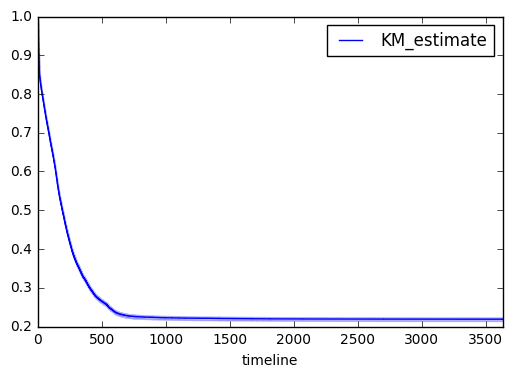

In [29]:
km = lifelines.KaplanMeierFitter()

km.fit(data["Number Of Days Until Approved"])
km.plot();

In [32]:
data.to_csv('./data/trackitt_data.csv', index=False, encoding='utf-8')